
<h1> W261 Final Project - Clickthrough Rate Prediction</h1>



## Table of Contents

* __Notebook Setup__
* __Section 1__ - Question Formulation
* __Section 2__ - Algorithm Explanation
* __Section 3__ - EDA & Challenges
* __Section 4__ - Algorithm Implementation
* __Section 5__ - Course Concepts

# Notebook Setup

In [1]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import pyspark
from pyspark.sql.functions import isnan, when, count, col ,trim,struct, udf
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType
from pyspark.sql import Window
from pyspark.sql.types import DoubleType
import math
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import FeatureHasher
from pyspark.ml.feature import PCA as PCAml
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [4]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "finalProj_notebook"
master = "local[*]"
config = pyspark.SparkConf().setAll([('spark.executor.memory', '16g'), ('spark.executor.cores', '6'), ('spark.cores.max', '6'), ('spark.driver.memory','16g'), ('spark.local.dir', '/sparkTemp')])
spark = SparkSession\
        .builder\
        .config(conf=config)\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

# Section 1 - Question Formulation

The goal of this analysis to develop a working scalable predictive model that helps advertising technologies programmatically determine who to show a specific ad, with the goal of maximizing clicks. This analysis is important because advertising platforms seek to optimize the success of display ads for their clients, and their bottom line is improved if more ad viewers are clicking on ads. Companies generally care about click-through-rates (CTR) because it results in more user traffic to their business application, resulting in higher revenue. In advertising platforms, the pricing structure is also often based on clicks rather than ad views, so increasing CTR is economical. In this analysis, we seek to answer the following question:  

Which future users who land on our website are most likely to click on a specific ad? 

The predictive model that we are developing in this project is meant to predict whether or not a future user will click on an ad. The data we are using for this prediction is a combination of numeric and categorical data, representing various attributes about the user who will view the ad as well as the attributes about the ad itself. 

In order for such a model to be practically applied, it would need to be retrained frequently and optimized to run predictions very fast. The prediction itself would need to be within milliseconds because it would be part of a real-time ad bidding system. While the retraining would need to occur frequently (e.g., daily) in order for the predictions to keep up with new trends, a more frequent training would be more ideal, requiring even more complex performance improvements. 

# Section 2 - Algorithm Explanation
### 2.1 Create our own toy example that matches the dataset provided and use this toy example to explain the math behind the algorithm that you will perform.

Logistic Regression is a popular method to predict a categorical response. In this project, we are implementing a logistic regression model to predict the click-through-rate based on the data provided by Criteo Labs. It is a special case of Generalized Linear models that predicts the probability of the outcomes. The predicted probability, $\hat{p}_i$, that it belongs to a given class is given by equation below: 

\begin{equation}\
\hat{p}_i = \frac{1}{1+\exp \left(-\mathbf{\theta}^{T} \cdot \mathbf{x}_i\right)}
\end{equation}

where $\theta := \begin{bmatrix} b \\ \mathbf{w} \end{bmatrix}$ and  $\mathbf{x}_i := \begin{bmatrix} 1 \\ x_i \end{bmatrix}$, and $\mathbf{w}$ is the vector of weights, $x_i$ is an input vector regarding Observation $i$, and $b$ is the bias term. .

Just like any other regression solution using gradient descent, we estimate weights by minimizing the cost function. Mean squared error (MSE) is not an appropriate cost function for a logistic regression model because it's not a convext function. Instead, we use average log loss as our cost function.  

$$ J(\mathbf{\theta}) = \frac{1}{n} \displaystyle\sum_{i=1}^{n} \text{LogLoss}_i$$  
where,   
$$ \text{LogLoss}_i = -y_i \cdot \log(\hat{p}_i) - (1-y_i) \cdot log(1-\hat{p}_i)$$

We derive the gradient below:

Let $z = \mathbf{\theta}^{T} \cdot \mathbf{x}_i$

$$
\begin{align}
\nabla_{\mathbf{\theta}} J(\mathbf{\theta}) &= \frac{1}{n} \displaystyle\sum_{i=1}^{n} \frac{\partial \text{LogLoss}_i}{\partial \mathbf{\theta}} \\
&= \frac{1}{n} \displaystyle\sum_{i=1}^{n} \Big(- y_i \cdot \frac{1}{\hat{p}_i} + (1-y_i) \cdot \frac{1}{1-\hat{p}_i} \Big) \cdot \frac{\partial \hat{p}_i}{\partial z} \cdot \frac{\partial z}{\partial \mathbf{\theta}} \\
&= \frac{1}{n} \displaystyle\sum_{i=1}^{n} \Big(- y_i \cdot \frac{1}{\hat{p}_i} + (1-y_i) \cdot \frac{1}{1-\hat{p}_i} \Big) \cdot \big[ \hat{p}_i(1-\hat{p}_i) \big] \cdot \mathbf{x}_i \\
&= \frac{1}{n} \displaystyle\sum_{i=1}^{n} (\hat{p}_i - y_i) \cdot \mathbf{x}_i 
\end{align}
$$

The vector of weights, $\mathbf{\theta}$, is initialized and then iteratively updated until it converges, as shown in equation below.  $\eta$ is the learning rate of the model.

\begin{equation}\
\mathbf{\theta}=\mathbf{\theta}-\eta \cdot \nabla_{\mathbf{\theta}} J(\mathbf{\theta})
\end{equation}

To avoid overfitting, we may regularize the gradient descent. For doing this, we introduce a regularization coefficient $\lambda$ multiplied by either L1 norm (Lasso) or L2 norm(Ridge).

The objective function and gradient for lasso regression is shown below:

\begin{equation}\
\nabla_{\mathbf{\theta}} J(\mathbf{\theta}) = \frac{1}{n} \displaystyle\sum_{i=1}^{n} (\hat{p}_i - y_i) \cdot \mathbf{x}_i + \text{sign}(\mathbf{w})
\end{equation}

The objective function and gradient for ridge regression is shown below:

\begin{equation}\
\nabla_{\mathbf{\theta}} J(\mathbf{\theta}) = \frac{1}{n} \displaystyle\sum_{i=1}^{n} (\hat{p}_i - y_i) \cdot \mathbf{x}_i + 2 \lambda \mathbf{w}
\end{equation}

In our implementaion, regularization can be turned on by setting parameters `regType` and `regParam`. 

### 2.2 Application to Toy Dataset

To explain the understanding of math calculations behind this , we randomly pick 5 samples from train.txt as a toy example with two numeric features (`x1`,`x2`) and one 1 hot encoded categorical column `x3` 

| y | x1 | x2 | x3 |
|---|----|----|----|
| 0 | 1  | 2  | 1  | 
| 0 | 2  | 4  | 1  |
| 1 | 1  | 0  | 1  |
| 1 | 0  | 2 | 0  |
| 1 | 3  | 6 | 0  |

The logistic regression model makes a prediction as to the probability of input belonging to the default class (class 1). If the probabilty is greater than 0.5, it classifies as default class 0; or else it is class 0.

For this toy example, we need to estimthe 4 coefficients ($w_0$, $w_1$, $w_2$, and $w_3$). The job of our model is to discover the best values for all coefficients based on training dataset. The output will then be transformed into a probability using logistic function.

$$ z = w_0 + w_1 x_1 + w_2 x_2 + w_3 x_3 $$

$$ \hat{p}(class = 1) = \frac{1}{1 + e^{-z}} $$

There are many variants of gradient descent. In our homegrown logistic regression function, full gradient descent is implemented where coefficients are updated after the calculation of cost for the entire dataset. Below illustrates one descent step.

We initialize all coefficients as 0: 
$$ \boldsymbol{\theta} = \begin{bmatrix} 0 \\ 0 \\ 0 \\ 0 \\ \end{bmatrix}$$  

Our input vector $\mathbf{x}_i$ for first row is:
$$  \mathbf{x}_1 = \begin{bmatrix} 1 \\ 1 \\ 2 \\ 1 \\ \end{bmatrix} $$ 

True y for the first row is:
$$ y_1 = 0 $$ 

Gradient for the first row is calculated as follows: 
$$z = w_0 + w_1 x_1 + w_2 x_2 + w_3 x_3 = 0$$  
$$\hat{p}_1 = \frac{1}{1 + e^{-z}} = 0.5$$  
$$\text{Gradient}_1 = (\hat{p}_1 - y_1) \cdot \mathbf{x}_1 = 0.5 \begin{bmatrix} 1 \\ 1 \\ 2 \\ 1\\ \end{bmatrix} = \begin{bmatrix} 0.5 \\ 0.5 \\ 1 \\ 0.5\\ \end{bmatrix} $$  

Follow the same formula, we can calculate gradient for each observation:

|  $x_j '$  | $y_j$ |   $\mathbf{\theta}^{T} \cdot \mathbf{x}_i$ | $\frac{1}{1 + e^{-z}}$ | $(\hat{p}_1 - y_1) \cdot \mathbf{x}_i$ |
|:------:|:------:|:------:|:--------------:|:---------------:|
|  input   | true y   |   Linear Predictor   |  Predicted y  | $\text{gradient}_i$ | 
| $ \begin{bmatrix} 1 \\ 1 \\ 2 \\ 1 \\ \end{bmatrix}$   | 0 |  0 | 0.5   |  $\begin{bmatrix} 0.5 \\ 0.5 \\ 1 \\ 0.5 \\ \end{bmatrix}$
| $ \begin{bmatrix} 1 \\ 2 \\ 4 \\ 1 \\ \end{bmatrix}$   | 0 |  0 | 0.5   |  $\begin{bmatrix} 0.5 \\ 1 \\ 2 \\ 0.5 \\ \end{bmatrix}$
| $ \begin{bmatrix} 1 \\ 1 \\ 0 \\ 1 \\ \end{bmatrix}$   | 1 |  0 | 0.5   |  $\begin{bmatrix} 0.5 \\ 0.5 \\ 0 \\ 0.5 \\ \end{bmatrix}$
| $ \begin{bmatrix} 1 \\ 0 \\ 2 \\ 0 \\ \end{bmatrix}$   | 1 |  0 | 0.5   |  $\begin{bmatrix} 0.5 \\ 0 \\ 1 \\ 0 \\ \end{bmatrix}$
| $ \begin{bmatrix} 1 \\ 3 \\ 6 \\ 0 \\ \end{bmatrix}$   | 1 |  0 | 0.5   |  $\begin{bmatrix} 0.5 \\ 1.5 \\ 3 \\ 0 \\ \end{bmatrix}$

$$ \nabla_{\mathbf{\theta}} J = \frac{1}{5} \Bigg( \begin{bmatrix} 0.5 \\ 0.5 \\ 1 \\ 0.5 \\ \end{bmatrix} + \begin{bmatrix} 0.5 \\ 1 \\ 2 \\ 0.5 \\ \end{bmatrix} + \begin{bmatrix} 0.5 \\ 0.5 \\ 0 \\ 0.5 \\ \end{bmatrix} +  \begin{bmatrix} 0.5 \\ 0 \\ 1 \\ 0 \\ \end{bmatrix} + \begin{bmatrix} 0.5 \\ 1.5 \\ 3 \\ 0 \\ \end{bmatrix} \Bigg) = \begin{bmatrix} 0.5 \\ 0.7 \\ 1.4 \\ 0.3 \\ \end{bmatrix}$$ 

With learning rate of $\boldsymbol{\eta} = 0.1$, the new coefficients are: 
$$ \boldsymbol(\theta) - \eta \nabla_{\boldsymbol{\theta}} J =  \begin{bmatrix} 0 \\ 0 \\ 0 \\ 0 \\ \end{bmatrix} - 0.1 \begin{bmatrix} 0.5 \\ 0.7 \\ 1.4 \\ 0.3 \\ \end{bmatrix} = \begin{bmatrix} -0.05 \\ -0.07 \\ -0.14 \\ -0.03 \\ \end{bmatrix} $$ 

In the code below, we run our home grown implementation of logistic regression on this toy example. The output shows the cost and weights of the model after 10 iterations, and the history of the cost as the model progresses through each iteration of gradient descent. 

In [1]:
def homeGrownLogistic(dataRDD, learningRate=0.1, regType='None', regParam=0.1, iterNum=0, tol=0.001, verbose=0):
    """
    Perform one gradient descent step/update with ridge or lasso regularization.
    Args:
        dataRDD - tuple of (actual, prediction, [1, features])
        learningRate - (float) defaults to 0.1
        regType - (str) 'ridge' or 'lasso', defaults to None
            regParam - (float) regularization term coefficient, defaults to 0.1
        iterNum - (int) number of iterations of gradient descent, max number of iterations is 1000
            tol - (float) tolerance of max change in gradient if iterNum is not specified by user or <= 0
        verbose - (int) 1 to print additional info, defaults to 0
    Returns:
        a dictionary that is composed of:
        weight - (array) parameter estimates, bias at index 0
        history_cost - (list) cost after each iteration
    """
    
    ## To resolve math overflow error
    ## Reference: https://stackoverflow.com/questions/36268077/overflow-math-range-error-for-log-or-exp?rq=1
    def sigmoid(x):
        if x < 0:
            return 1 - 1/(1 + math.exp(x))
        else:
            return 1/(1 + math.exp(-x))

    def mapper_update_cost_gradient(line):
        """
        This mapper performs 3 tasks:
        - Update the prediction based on new weights
        - Calculate cost
        - Calculate gradient

        INPUT: actual, prediction, (1, features)
        OUTPUT: cost, gradient as a list
        """
        (actual, pred, feature) = line

        z = np.sum(np.array(feature)*weight_bc.value)
        ## Bound the prediction between 0.000001 and 0.999999 
        ##     so that log(prediction) or log(1-prediction) doesn't encounter math domain error
        pred = min(max(sigmoid(z), 0.000001), 0.999999)

        if actual == 1:
            cost = - math.log(pred)
        else:
            cost = - math.log(1-pred)

        gradient = np.array(feature)*(pred-actual)

        return (cost, gradient)

    
    dataRDD.cache()
    
    nObs = dataRDD.count()
    nFeature = len(dataRDD.take(1)[0][2])
    nFeature_bc = sc.broadcast(nFeature)
    
    ## Initialization
    weight_init_arr = np.zeros(nFeature)
#     weight_init_arr = np.array([0.02, 0.001, -0.002, 0, -0.1])
    weight_arr = weight_init_arr
    old_grad_arr = np.zeros(nFeature)
    max_chg_grad = 1000 # an arbitrary large number
    history_cost_lst = []
    
    
    for i in range(1000):
        if iterNum > 0:
            if i == iterNum:
                break
        else:
            if max_chg_grad < tol:
                break

        weight_bc = sc.broadcast(weight_arr)
        cost_gradient_temp = dataRDD.map(mapper_update_cost_gradient).reduce(lambda x, y: (x[0]+y[0],x[1]+y[1]))

        cost = cost_gradient_temp[0] / nObs
        history_cost_lst.append(cost)

        grad_arr = cost_gradient_temp[1] / nObs
        if regType == 'lasso':
            grad_arr += regParam*np.append([0.0], np.sign(weight_arr[1:]))
        elif regType == 'ridge':
            grad_arr += 2*regParam*np.append([0.0], weight_arr[1:])
            
        max_chg_grad = np.max(np.abs(grad_arr - old_grad_arr))
        old_grad_arr = grad_arr
        
        step_arr = grad_arr * learningRate
        weight_arr -= step_arr

        if verbose == 1:
            print("--------------")
            print(f'ITERATION: {i+1}')  
            print(f'cost_gradient_temp is {cost_gradient_temp}')
            print(f'Gradients are {grad_arr}')
            print(f'Max change in gradient is {max_chg_grad}')
            print(f'Weights are {weight_arr}')
            print(f'cost is {cost}')
        else:
            if (i+1) % 10 == 0:
                print(f'ITERATION {i+1}: cost = {cost}')
    
    if i % 10 != 0:
        print(f'ITERATION {i}: cost = {cost}')
        
    return {'weight': weight_arr, 'history_cost': history_cost_lst}

We built the homegrown logistic regression function based on these two references: 
* https://www.internalpointers.com/post/cost-function-logistic-regression  
* https://towardsdatascience.com/optimization-loss-function-under-the-hood-part-ii-d20a239cde11

In [14]:
# Create Toy data set for homegrown
toy_df_hg = spark.createDataFrame(
    [(0.0,1.0,[1, 2, 1]),
     (0.0,2.0,[2, 4, 1]),
     (1.0,1.0,[1, 0, 1]),
     (1.0,0.0,[0, 2, 0]),
     (1.0,3.0,[1, 6, 0]),
     ],
    ["actual", "prediction","features"])

# Transform dataset for home grown model function
toy_hg_rdd = toy_df_hg.rdd.map(lambda row: (row.actual,row.prediction, tuple([1]+list(row.features))))
toy_hg_rdd.cache()  

# Run home grown model and time it
start = time.time()
result = homeGrownLogistic(toy_hg_rdd, learningRate=0.1, regType="none", iterNum=10)
print('----')
print('model weights: ',result['weight'])
print('----')
print('cost per iteration',result['history_cost'])
print('----')
print(f'... logistic model trained in {time.time() - start} seconds.')

ITERATION 10: cost = 0.6568145865083382
----
model weights:  [ 0.07620662 -0.12118341  0.08147204 -0.1029171 ]
----
cost per iteration [0.6931471805599452, 0.6866844439068702, 0.6817338530204186, 0.6775022786261939, 0.6736464057556342, 0.6700157349206849, 0.6665424521012513, 0.6631944203505695, 0.6599550421779657, 0.6568145865083382]
----
... logistic model trained in 1.2811481952667236 seconds.


# Section 3 - EDA & Challenges

### 3.1 Get the data

In [13]:
data/train.txt').map(lambda x: x.split("\t"))
testRawRDD = sc.textFile('data/test.txt').map(lambda x: x.split("\t"))

### 3.2 Split into Train and Validation Set

The test data we downloaded doesn't have a target variable and thus cannot be used for model development and tuning so we split the training data into training and validation sets.

In [14]:
trainRDD, validationRDD = trainRawRDD.randomSplit([0.7,0.3], seed = 1)
print(f"... held out {validationRDD.count()} records for evaluation and assigned {trainRDD.count()} for training.")

... held out 13754755 records for evaluation and assigned 32085862 for training.


### 3.3 Convert to Spark DataFrame

From Kaggle we know that the first column is the label (our target variable), columns 2-14 are numerical columns and columns 15-40 are categorical. We will rename these columns so that we can distinguish between label, numerical data, and categorical data

In [15]:
# create header for dataset with numeric and categorical features
numeric_features = ['I'+str(i) for i in range(1,14)]
categorical_features = ['C'+str(i) for i in range(1,27)]
header = ['Label'] + numeric_features + categorical_features
trainDF = trainRDD.toDF(header)
#trainDF.printSchema()
trainDF.show(5)

+-----+---+---+---+---+-----+---+---+---+---+---+---+---+---+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|Label| I1| I2| I3| I4|   I5| I6| I7| I8| I9|I10|I11|I12|I13|      C1|      C2|      C3|      C4|      C5|      C6|      C7|      C8|      C9|     C10|     C11|     C12|     C13|     C14|     C15|     C16|     C17|     C18|     C19|     C20|     C21|     C22|     C23|     C24|     C25|     C26|
+-----+---+---+---+---+-----+---+---+---+---+---+---+---+---+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|    0|  1|  1|  5|  0| 1382|  4| 15|  2|181|  1|  2|   |  2|68fd1e64|80e26c9b|fb936136|7b4723c4|25c83c98|7e0ccc

In [16]:
## Apply the header to the validation RDD as well
validationDF = validationRDD.toDF(header)

In [17]:
# cast integer variables to integer type
for var in ['Label'] + numeric_features:
    trainDF = trainDF.withColumn(var, trainDF[var].cast(IntegerType()))
    validationDF = validationDF.withColumn(var, validationDF[var].cast(IntegerType()))

### 3.4. Count the Number of Missing Values in Each Feature

A key step in our EDA is to examine any missing values in the dataset. Many algorithms, such as Principle Component Analysis (PCA) and logistic regression, do not work well with missing values. If we have missing values in the data, we need to be thoughtful about how to handle this challenge for our modeling to be successful. 

For missing numeric variables, they show up as `NaN`. For some reason, missing categorical variables are not recognized as `NaN`, replace them with `None`.

In [18]:
# replace missing categorical variables not recognized as NA with the None
trainDF = trainDF.replace('', None, categorical_features)
validationDF = validationDF.replace('', None, categorical_features)

In the table below, we calculate the percentage of missing values for each feature. Only features with missing values are displayed.

In [20]:
# look at missing statistics
total_count = trainDF.count()
non_missing = trainDF.summary("count")
missing_summary = non_missing.toPandas().drop(['summary'], axis=1).transpose()
missing_summary.columns = ['non-missing']
missing_summary['missing'] = total_count - missing_summary['non-missing'].astype('int64')
missing_summary['missing_pct'] = missing_summary['missing'] / total_count
missing_summary[missing_summary.missing_pct>0].sort_values(['missing_pct'], ascending=False)

,non-missing,missing,missing_pct
I12,7537975,24547887,0.765069
C22,7619405,24466457,0.762531
I1,17532227,14553635,0.453584
I10,17532227,14553635,0.453584
C25,17967683,14118179,0.440012
C20,17967683,14118179,0.440012
C19,17967683,14118179,0.440012
C26,17967683,14118179,0.440012
I6,24910105,7175757,0.223642
I13,25129289,6956573,0.216811


24 of 39 features have missing values. Some features such as `I12`, `C22` have around 76.5% missing values. The target variable doesn't have any missing values, which is important, otherwise we would have to remove the rows where the target variable were missing. How we handle this challenge of missing values is discussed further in Section 3.9 Summary of Challenges. 

Below we create a list of features with missing values, which will be used later when we apply missing value treatment.

In [21]:
numeric_features_miss = ["I1","I3","I4","I5","I6","I7","I8","I9","I10","I11","I12","I13"]
categorical_features_miss = ["C3","C4","C6","C12","C16","C19","C20","C21","C22","C24","C25","C26"]
features_miss = numeric_features_miss + categorical_features_miss

features_miss0_dict = dict()
for feature in numeric_features_miss:
    features_miss0_dict.update({feature: 0})
    
for feature in categorical_features_miss:
    features_miss0_dict.update({feature: '0'})
    
print(features_miss0_dict)

{'I1': 0, 'I3': 0, 'I4': 0, 'I5': 0, 'I6': 0, 'I7': 0, 'I8': 0, 'I9': 0, 'I10': 0, 'I11': 0, 'I12': 0, 'I13': 0, 'C3': '0', 'C4': '0', 'C6': '0', 'C12': '0', 'C16': '0', 'C19': '0', 'C20': '0', 'C21': '0', 'C22': '0', 'C24': '0', 'C25': '0', 'C26': '0'}


### 3.5 Check for Class Imbalance

For a classification problem, it's importance to check whether classes are balanced or not. If one class has significantly more observations than the other (i.e., class are imbalanced), we need to consider a few options such as the following:  
* Oversample the minority class  
* Undersample the majority class  
* Use a performance metric other than accuracy  

The list above is not exhausive but only includes some common tactics.

In [22]:
# look at target variable distribution
trainDF.groupBy('Label').count().toPandas()

,Label,count
0,1,8220552
1,0,23865310


Roughly 25% ($ =8220552/(8220552+23865310)$) of the data is labeled as 1. The classes are mildly imbalanced.

How we handle this challenge of class imbalance is discussed further in Section 3.9 Summary of Challenges. 

### 3.6 Correlations among Numeric Features and with the Target

Next, we take 1% of dataset as the sample to perform more EDA with summary statistics, correlation matrix, and histogram for numeric features, and summary statistics for categorical features.

In [23]:
# take 1% of data as a sample for more EDA
sampleDF = trainDF.sample(False,0.01,261).cache()
sampleDF.count()

320424

Certain models, such as regression models, require little or no multicollinearity, so we want to check the correlations between numeric features. For features with strong correlations, we can (1) perform variable clustering, (2) drop highly correlated features, and (3) use PCA to create orthogonal features.  
We will examine the correlation matrix first.

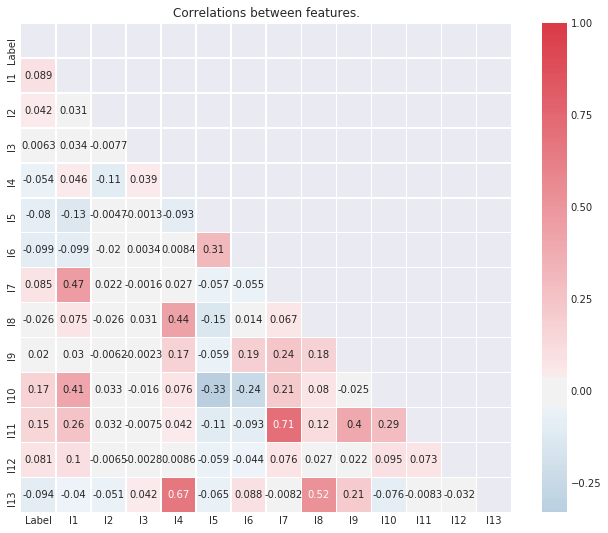

In [16]:
# Correlation between the dependent variables
numeric_data = sampleDF.select(['Label'] + numeric_features).toPandas()
corr = numeric_data.corr()
fig,ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True,center=0, linewidths=.5)
plt.title("Correlations between features.")
plt.show()

We noticed that a few variables are relatively correlated. For example `I7` and `I11`, `I4` and `I8`, `I14` and `I13`, `I1` and `I10`, `I8` and `I13` have correlation coefficients greater than 0.4, with highest correlation of 0.71. We will take one of the three actions listed above before running a logistic regression model. 

The target variable `Label` is weakly positively correlated with `I10` and `I11`.

### 3.7 Descriptive Analysis on Numeric Features

Another thing we want to look at is the distributions of numeric features. If features have significantly different means and standard deviations, Gradient Descent takes steps in suboptimal directions and takes longer to run. 

In [17]:
sampleDF.select(numeric_features[:7]).describe().show()

+-------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+
|summary|                I1|                I2|                I3|               I4|               I5|                I6|                I7|
+-------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+
|  count|            175027|            320424|            251279|           250874|           312286|            248699|            306393|
|   mean|3.4875762025287527|105.91240044441116|26.441477401613348|7.321914586605228|18611.46090122516|114.73418469716404|16.369182716315322|
| stddev| 9.273054052817852| 389.3028876716936| 406.8141727013279| 8.69686527812395|69583.08516636734|329.73313428383074| 63.74876930521864|
|    min|                 0|                -2|                 0|                0|                0|                 0|                 0|
|    max|    

In [18]:
sampleDF.select(numeric_features[7:]).describe().show()

+-------+------------------+------------------+------------------+-----------------+-----------------+-----------------+
|summary|                I8|                I9|               I10|              I11|              I12|              I13|
+-------+------------------+------------------+------------------+-----------------+-----------------+-----------------+
|  count|            320266|            306393|            175027|           306393|            74948|           250874|
|   mean|12.546567540731766| 106.3076832695264| 0.617944659966748|2.745529434419194|1.012635427229546|8.202938526909923|
| stddev|18.606387143970668|221.57141201889365|0.6825324578258775|5.234907023394712|5.740601156484362|13.31715860280245|
|    min|                 0|                 0|                 0|                0|                0|                0|
|    max|              4554|             14158|                 8|              127|              493|             2341|
+-------+------------------+----

The basic descriptive statistics above show the average values of numeric features vary greatly from 0.62 (`I10`) to 18611 (`I5`). The coefficients of variation, the ratio of standard deviation to mean, also vary greatly among features. In addition, the maximum values for all features are significantly further from their means than their minimum values are. This indicates all the numeric features are highly skewed to the right. 

We can visualize the distributions through plotting histograms the sample data.

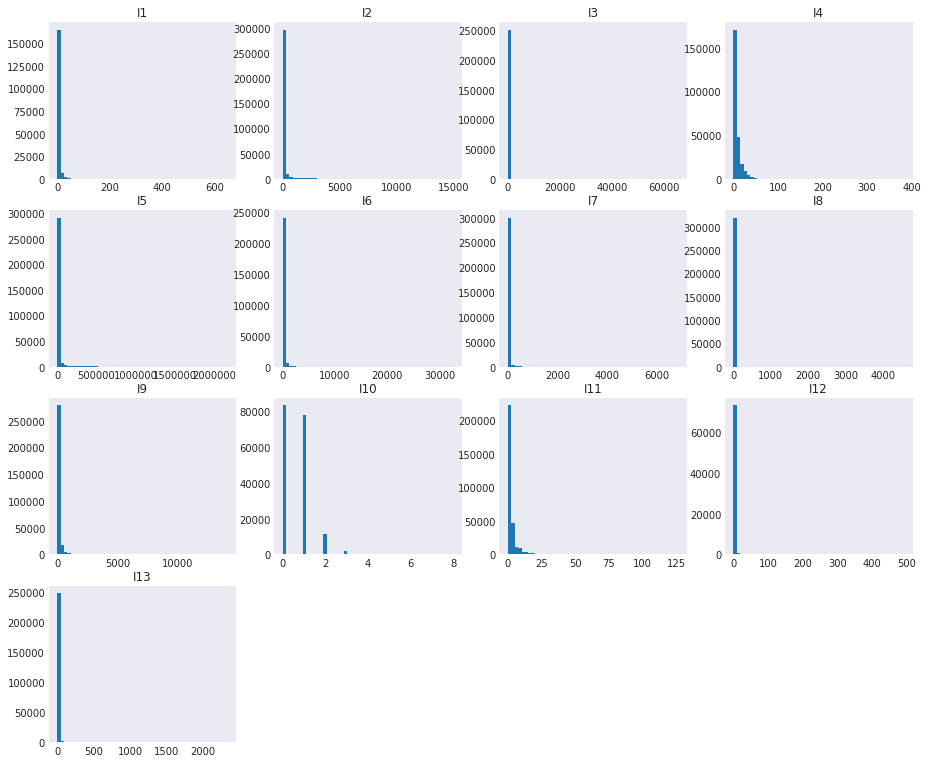

In [19]:
# Histogram of numeric features
sample_pd = sampleDF.toPandas()
dim = np.ceil(np.sqrt(len(sample_pd.columns[1:14])))
fig = plt.figure(figsize=(6,4))
fig.subplots_adjust(left=0, right=2, bottom=0, top=2.5)
for i,c in enumerate(trainDF.columns[1:14]):
# for each numerical variable, plot a histogram of non-missing values
    ax = fig.add_subplot(dim, dim, i + 1)
    ax.hist(sample_pd[c].dropna(), bins=50)
    ax.set_title(sample_pd.columns[i + 1])

As confirmed by the histograms above, we have extreme skewness in all our numeric variables. This poses challenges when we later implement gradient descent in logistic regression models, which we should address through normalization. In Section 5, we will explain normalization in greater details. Below, we demonstrate two common normalization techniques (log scaling and z-score) and their effect on the sample data. 

(1) Log scaling

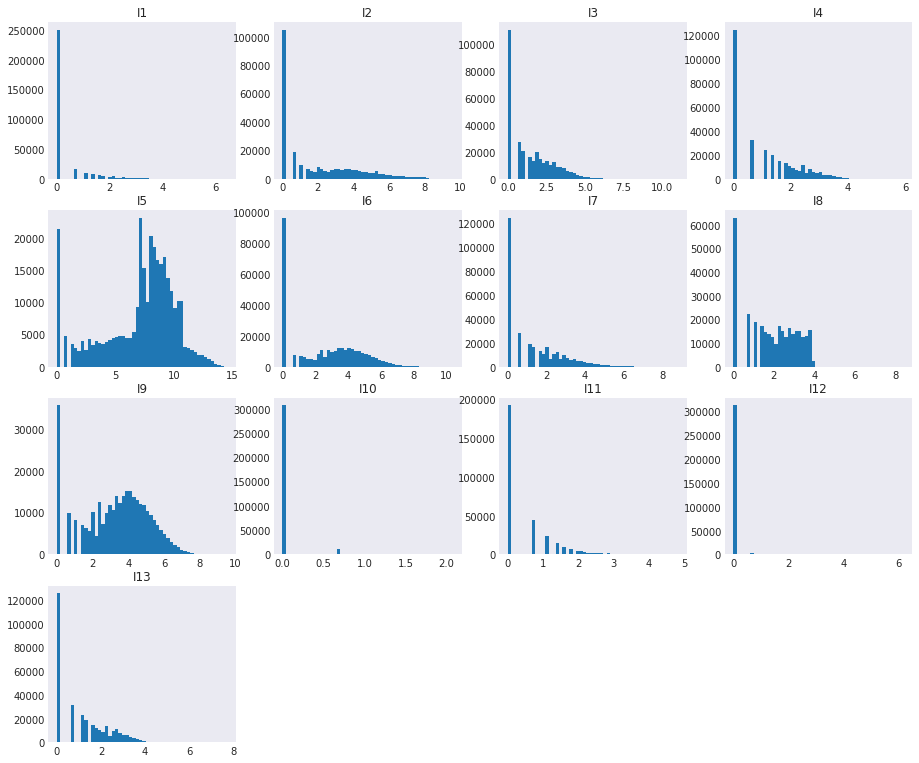

In [20]:
# Histogram of log transformed numeric features

# set up the subplots figure
dim = np.ceil(np.sqrt(len(sample_pd.columns[1:14])))
fig = plt.figure(figsize=(6,4))
fig.subplots_adjust(left=0, right=2, bottom=0, top=2.5)
for i, col in enumerate(sample_pd.columns[1:14]):
    # add the subplot
    ax = fig.add_subplot(dim, dim, i + 1)
        
    # replace the missing values with 0
    c = sample_pd[col].copy()
    c.fillna(0, inplace=True)
        
    # take natural log of nonzero values (to avoid -inf)
    c[c != 0] = c[c != 0].apply(np.log)
        
    # plot histogram
    ax.hist(c.dropna(), bins=50)
    ax.set_title(sample_pd.columns[i + 1])

(2) Clipping

In [52]:
def capNumeric(df):
    capNumeric_lst = [25, 300, 150, 50, 50000, 600, 100, 50, 500, 3, 20, 5, 50]
    for i, column in enumerate(numeric_features):
        df = df.withColumn(column+"_cap", when(F.col(column) > capNumeric_lst[i], capNumeric_lst[i]).otherwise(F.col(column)))
    df.cache()
    return df

In [55]:
capNumeric(sampleDF)

DataFrame[Label: int, I1: int, I2: int, I3: int, I4: int, I5: int, I6: int, I7: int, I8: int, I9: int, I10: int, I11: int, I12: int, I13: int, C1: string, C2: string, C3: string, C4: string, C5: string, C6: string, C7: string, C8: string, C9: string, C10: string, C11: string, C12: string, C13: string, C14: string, C15: string, C16: string, C17: string, C18: string, C19: string, C20: string, C21: string, C22: string, C23: string, C24: string, C25: string, C26: string, I1_cap: int, I2_cap: int, I3_cap: int, I4_cap: int, I5_cap: int, I6_cap: int, I7_cap: int, I8_cap: int, I9_cap: int, I10_cap: int, I11_cap: int, I12_cap: int, I13_cap: int]

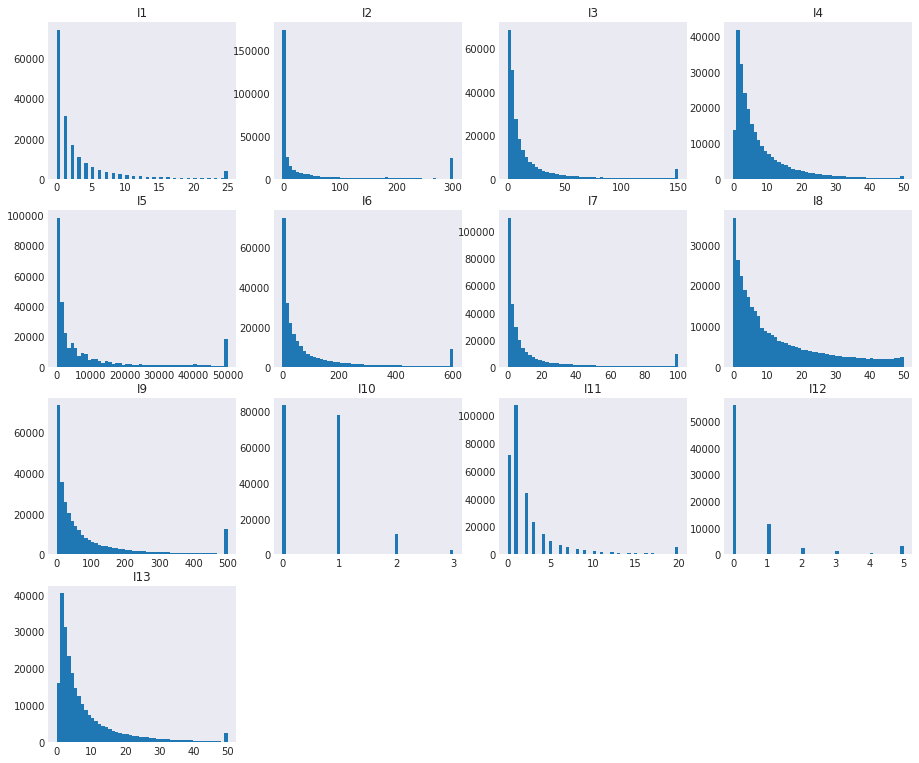

In [54]:
# Histogram of numeric features
sample_pd = sampleDF.toPandas()
dim = np.ceil(np.sqrt(len(sample_pd.columns[-13:])))
fig = plt.figure(figsize=(6,4))
fig.subplots_adjust(left=0, right=2, bottom=0, top=2.5)
for i,c in enumerate(sampleDF.columns[-13:]):
# for each numerical variable, plot a histogram of non-missing values
    ax = fig.add_subplot(dim, dim, i + 1)
    ax.hist(sample_pd[c].dropna(), bins=50)
    ax.set_title(sample_pd.columns[i + 1])

### 3.8 Descriptive Analysis on Categorical Features

We now examine the categorical features. In order to understand the size of our feature space, we need to understand the number of unique features (classes) in each categorical variable.

The table below shows the following statistics for each categorical variable in our dataset: 

* mode - the category that is most common within this variable
* count - the count of the mode category
* level - the number of unique categories within each variable

In [288]:
# look at summary statistics of categorical features in sample (mode, counts for mode, number of levels)
cat_summary = pd.DataFrame()
for i in categorical_features:
    cached = sampleDF.groupBy(i).count().cache()
    mode = cached.orderBy('count', ascending=0).filter(i + "!=''").limit(1).toPandas()
    level = cached.count()
    mode['level'] = level
    mode['var'] = i
    mode.rename(columns={i:'mode'}, inplace=True)
    cat_summary = cat_summary.append(mode, ignore_index = True)
cat_summary

,mode,count,level,var
0,05db9164,160396,871,C1
1,38a947a1,36604,542,C2
2,d032c263,7893,131570,C3
3,c18be181,11398,61171,C4
4,25c83c98,215116,187,C5
5,7e0ccccf,127307,13,C6
6,1c86e0eb,6698,10000,C7
7,0b153874,190238,391,C8
8,a73ee510,287981,3,C9
9,3b08e48b,70826,20393,C10


Here we observe that a lot of categorical variables have a large number of levels. This will increase our data size significantly after doing a one-hot encoding.

To prepare for our modeling, we want to find the total number of unique classes for the entire training data, not just the sample as analyzed above. Below we determine the total classes within each categorical variable. 

In [291]:
uniqueCounts = {}
for c in trainDF.columns[14:]:
    count = trainDF.agg(F.countDistinct(c).alias('c')).collect()[0]['c']
    uniqueCounts[c] = count
    
uniqueCounts

{'C1': 1460,
 'C2': 576,
 'C3': 7479734,
 'C4': 1715283,
 'C5': 305,
 'C6': 23,
 'C7': 12470,
 'C8': 633,
 'C9': 3,
 'C10': 86512,
 'C11': 5642,
 'C12': 6226827,
 'C13': 3194,
 'C14': 27,
 'C15': 14585,
 'C16': 4133545,
 'C17': 10,
 'C18': 5536,
 'C19': 2161,
 'C20': 3,
 'C21': 5293211,
 'C22': 17,
 'C23': 15,
 'C24': 243392,
 'C25': 104,
 'C26': 127633}

Some categorical features have extremely large number of unique categories. `C3`, `C12`, `C16`, `C21` each have more than 4 million distinct categories. The majority of other categorical featuress have more than 500 distinct categories each.  

If we encoded all categorical features using a one-hot encoding scheme, the feature space would be extremely large. In order to reduce the amount of time that takes models to run and avoid the curse of dimensionality, we need to reduce feature dimensions. We discuss our approach to handling this in Section 3.9 Summary of Challenges.

### 3.9 **Summary of Challenges** --------------------------------------------------------------------------------------<< 

The EDA analysis above has demonstrated four main challenges we are facing:  
> (1) Missing Values  
24 of 39 features in the training set have missing values. Some features such as `I12`, `C22` have around 76.5% missing values. Many algorithms do not work well with missing values. For example, in logistic regression models, prediction cannot be calculated if one or more features have missing values. So before we move onto the modeling phase (Section 4), we have to replace missing values with something else.  

> Depending on the cause of missing values, some missing values have predictive power while others don't. Since we do not know what each feature represents, it's hard to determine the nature of missing values. To be safe, we assume missing values are meaningful for modeling. In our implementation, we create a missing indicator for each feature with a missing value and impute a 0 for the missing numeric value (see Section 3.10 for implementation). 

> (2) Class Imbalances  
Roughly 25% of observations are in Class 1, which indicates an ad was clicked, while the remaining 75% of observations are in Class 0. The classes are mildly imbalanced. As mentioned in Section 3.5, there are three common techniques to deal with imbalanced data, such as oversampling the minority class, undersampling the majority class, or using a performance metric other than accuracy. For simplicity and due to time constraints, we chose the third option. If we had more time, we would have compared model performance among those three options.

> Accuracy is not a good measure of model performance in the case of imbalanced data. A model that predicts every observation as 0 scores 75% on accuracy even though the model is practically useless in predicting ad click. Instead, we should use F1 score (the harmonic average of precision and recall). Precision measures the ratio of actual ad clicks to the total predicted ad clicks. Recall measures the ratio of predicted ad clicks to the total actual ad clicks. Since we want to maximize both precision and recall, F1 score is a good metric that balances both precision and recall and takes into account both false positives and false negatives.

> (3) Large Feature Space  
Our data has 13 numetric features and 26 categorical features. There are in total of 25,352,901 distinct categories across 26 categorical features. If we encoded all categorical features using a one-hot encoding scheme, we would have 253,528,88 features (= number of numeric features + total number of distinct categories in categorical features - number of categorical features = 13 + 25,352,901 - 26). This would create at least two issues, 1) It would take a very long to train a model with that many features, and 2) The number of features are too large relative to the number of observations in the training data, which would result in severe overfitting and unstable parameter estimates. We will apply two techniques to reduce feature dimensions - feature hashing (Section 3.11) and principal component analysis (Section 3.12). 

> (4) Numeric features with significantly different means and scales  
13 numeric features have significantly different means and scales and are highly skewed. Without feature scaling or normalization, the surface of the logistic regression cost function will have high curvature ellipse, which will result in gradient descent taking steps toward suboptimal directions. Normalization will help reduce thos curvature and make it more circular. Correspondingly, it will take less steps for gradient descent to reach the minimum. 


### 3.10 Handle Missing Values

Create a missing value indicator for every feature with missing values, and replace missing values in the original features with 0 for numeric and '0' for categorical

In [24]:
## Below are lists of features with missing values, which has been defined in Section 3.4
# numeric_features_miss = ["I1","I3","I4","I5","I6","I7","I8","I9","I10","I11","I12","I13"]
# categorical_features_miss = ["C3","C4","C6","C12","C16","C19","C20","C21","C22","C24","C25","C26"]
features_miss = numeric_features_miss + categorical_features_miss

## Create a dictionary
##     Key: features with missing values
##     Value: the value NaN should be replaced with
features_miss0_dict = dict()
for feature in numeric_features_miss:
    features_miss0_dict.update({feature: 0})
for feature in categorical_features_miss:
    features_miss0_dict.update({feature: '0'})
    
def handleMissing(df):
    ## Create missing indicator for each feature with missing values
    for column in features_miss:
        df = df.withColumn(column+"_missInd", when(F.col(column).isNull(), 1).otherwise(0))
    ## Replace missing values in the original features with 0 for numberic features and '0' for categorical features
    df = df.fillna(features_miss0_dict)
    df.cache()
    return df

In [25]:
trainDF_noMiss = handleMissing(trainDF)
validationDF_noMiss = handleMissing(validationDF)

In [26]:
trainDF_noMiss.show(1)

+-----+---+---+---+---+----+---+---+---+---+---+---+---+---+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---+--------+--------+--------+--------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
|Label| I1| I2| I3| I4|  I5| I6| I7| I8| I9|I10|I11|I12|I13|      C1|      C2|      C3|      C4|      C5|      C6|      C7|      C8|      C9|     C10|     C11|     C12|     C13|     C14|     C15|     C16|     C17|     C18|     C19|     C20|     C21|C22|     C23|     C24|     C25|     C26|I1_missInd|I3_missInd|I4_missInd|I5_missInd|I6_missInd|I7_missInd|I8_missInd|I9_missInd|I10_missInd|I11_missInd|I12_missInd|I13_missInd|C3_missI

### 3.11 Feature Hashing (a.k.a. The Hashing Trick)

Feature hashing is a powerful technique for handling sparse, high-dimensional features in machine learning. It is fast, simple, memory-efficient, and well-suited to online learning scenarios. While an approximation, it has surprisingly low accuracy tradeoffs in many machine learning problems.
The core idea behind feature hashing is relatively simple: Instead of maintaining a one-to-one mapping of categorical feature values to locations in the feature vector, we use a hash function to determine the feature's location in a vector of lower dimension.This is done using the hashing trick to map features to indices in the feature vector. More discussions on feature hashing are in Section 5.2.

The number of features has to be power of 2, so we decided to use 32.  

In [27]:
# 2^n 
numFeatures_hashing = 2**5
hasher = FeatureHasher(inputCols=categorical_features,
                        outputCol="FH_features",
                        numFeatures = numFeatures_hashing)
pipeline = Pipeline(stages=[hasher])
model = pipeline.fit(trainDF_noMiss)
featTrainDF = model.transform(trainDF_noMiss)
featValDF = model.transform(validationDF_noMiss)

In [28]:
featTrainDF.show(1,truncate=False)

+-----+---+---+---+---+----+---+---+---+---+---+---+---+---+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---+--------+--------+--------+--------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------------------------------------------------------------------------------------------------------------------------------------------------+
|Label|I1 |I2 |I3 |I4 |I5  |I6 |I7 |I8 |I9 |I10|I11|I12|I13|C1      |C2      |C3      |C4      |C5      |C6      |C7      |C8      |C9      |C10     |C11     |C12     |C13     |C14     |C15     |C16     |C17     |C18     |C19     |C20     |C21     |C22|C23     |C24     |C25     |C2

Features constructed from feature hashing are in a vector form, so we need to extract those features out.

In [32]:
## Create a list of feature names that has surfix "_missInd"
feature_missInd_lst = []
for feature in features_miss:
    feature_missInd_lst.append(feature+"_missInd")
        
def extract_FeatureHashing_features(df):
    
    ## Create the header for df2
    header2 = ['Label'] + numeric_features + feature_missInd_lst
    
    def extract_FH(row):
        return (row.Label,row.I1,row.I2,row.I3,row.I4,row.I5,row.I6,row.I7,row.I8,row.I9,row.I10,row.I11,row.I12,row.I13,row.I1_missInd,row.I3_missInd,row.I4_missInd,row.I5_missInd,row.I6_missInd,row.I7_missInd,row.I8_missInd,row.I9_missInd,row.I10_missInd,row.I11_missInd,row.I12_missInd,row.I13_missInd,row.C3_missInd,row.C4_missInd,row.C6_missInd,row.C12_missInd,row.C16_missInd,row.C19_missInd,row.C20_missInd,row.C21_missInd,row.C22_missInd,row.C24_missInd,row.C25_missInd,row.C26_missInd,) + tuple(row.FH_features)
#         r=[]
#         for col in header2:
#             r.append(row.__getattr__(col))
#         return tuple(r) + tuple(row.FH_features)
        
    def mapper_int(line):
        temp_lst = []
        for i in line:
            temp_lst.append(int(i))
        return tuple(temp_lst)

    dataRDD = df.rdd.map(extract_FH)
    
    ## Had to convert to int first because toDF doesn't like numpy.float64
    df2 = dataRDD.map(mapper_int).toDF(header2) # Vector values will be named _2, _3, ...
    
    return df2

In [33]:
featTrainDF2 = extract_FeatureHashing_features(featTrainDF)
featValDF2 = extract_FeatureHashing_features(featValDF)

### 3.12 Principal Component Analysis (PCA)

Principal component analysis is a common technique for dimension reduction. It trains a model to project vectors to a lower-dimensional space. To use PCA from pyspark.ml package, we need to convert features to a vector form first.

In [34]:
## Create a vector of all features in preparation for PCA
header3 = numeric_features + feature_missInd_lst
from pyspark.ml.feature import VectorAssembler
vecAssembler = VectorAssembler(inputCols=header3, outputCol="features")
featTrainDF3 = vecAssembler.transform(featTrainDF2)
featValDF3 = vecAssembler.transform(featValDF2)

Perform PCA

In [35]:
pca = PCAml(k=10, inputCol="features", outputCol="pca")
model = pca.fit(featTrainDF3)
featTrainDF_PCA_raw = model.transform(featTrainDF3)
featValDF_PCA_raw = model.transform(featValDF3)

In [36]:
featTrainDF_PCA_raw.show(1, False)
featValDF_PCA_raw.show(1, False)

+-----+---+---+---+---+----+---+---+---+---+---+---+---+---+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Label|I1 |I2 |I3 |I4 |I5  |I6 |I7 |I8 |I9 |I10|I11|I12|I13|I1_missInd|I3_missInd|I4_missInd|I5_missInd|I6_missInd|I7_missInd|I8_missInd|I9_missInd|I10_missInd|I11_missInd|I12_missInd|I13_missInd|C3_missInd|C4_missInd|C6_missInd|C12_missIn

We decide to keep 10 PCA components and save it in a format `(actual, prediction, [1, list of PCA components])`. No modeling has been performed so far. Prediction is initialized as 0.

In [37]:
featTrainDF_PCA = featTrainDF_PCA_raw.rdd.map(lambda row: (row.Label,0, np.array([1]+list(row.pca))))
featValDF_PCA = featValDF_PCA_raw.rdd.map(lambda row: (row.Label,0, np.array([1]+list(row.pca))))

### 3.13 Normalization

Perform mean normalization

In [39]:
def normalize(trainRDD,validationRDD):
    """
    Scale and center data round mean of each feature.
    Args:
        dataRDD - records are tuples of (actual, prediction, features_array)
    Returns:
        normedRDD - records are tuples of (actual, prediction, features_array)
    """
    featureMeans = trainRDD.map(lambda x: x[2]).mean()
    featureStdev = np.sqrt(trainRDD.map(lambda x: x[2]).variance())
    featureMeans_bc = sc.broadcast(featureMeans)
    featureStdev_bc = sc.broadcast(featureStdev)
    normedTrainRDD = trainRDD.map(lambda x: (x[0],x[1],(x[2]-featureMeans_bc.value)/featureStdev_bc.value))
    normedValidationRDD = validationRDD.map(lambda x: (x[0],x[1],(x[2]-featureMeans_bc.value)/featureStdev_bc.value))
    return normedTrainRDD, normedValidationRDD

In [40]:
start = time.time()
normedTrainRDD_final, normedValidationRDD_final = normalize(featTrainDF_PCA, featValDF_PCA)
print(f'... normalized in {time.time() - start} seconds.')

... normalized in 5028.4987280368805 seconds.


Since `1` in `(actual, prediction, [1, list of PCA components])` is a constnat, it becomes undefined after normalization. Replace it with 1.

In [42]:
def mapper_firstFeature1(line):
    (actual, pred, feature) = line
    feature = np.append(np.array([1]), feature[1:])
    return (actual, pred, feature)

normedTrainRDD_final = normedTrainRDD_final.map(mapper_firstFeature1)
normedValidationRDD_final = normedValidationRDD_final.map(mapper_firstFeature1)

# Section 4 - Algorithm Implementation

We have already taken our training data and performed the following steps (as shown in Seciton 3):

* Handle missing data
* Feature hashing 
* Principle Component Analysis
* Normalization

Finally, we run the data through our home grown logistic regression model (same function as in Section 2). 

In [7]:
def homeGrownLogistic(dataRDD, learningRate=0.1, regType='None', regParam=0.1, iterNum=0, tol=0.001, verbose=0):
    """
    Perform one gradient descent step/update with ridge or lasso regularization.
    Args:
        dataRDD - tuple of (actual, prediction, [1, features])
        learningRate - (float) defaults to 0.1
        regType - (str) 'ridge' or 'lasso', defaults to None
            regParam - (float) regularization term coefficient, defaults to 0.1
        iterNum - (int) number of iterations of gradient descent, max number of iterations is 1000
            tol - (float) tolerance of max change in gradient if iterNum is not specified by user or <= 0
        verbose - (int) 1 to print additional info, defaults to 0
    Returns:
        a dictionary that is composed of:
        weight - (array) parameter estimates, bias at index 0
        history_cost - (list) cost after each iteration
    """
    
    ## To resolve math overflow error
    ## Reference: https://stackoverflow.com/questions/36268077/overflow-math-range-error-for-log-or-exp?rq=1
    def sigmoid(x):
        if x < 0:
            return 1 - 1/(1 + math.exp(x))
        else:
            return 1/(1 + math.exp(-x))

    def mapper_update_cost_gradient(line):
        """
        This mapper performs 3 tasks:
        - Update the prediction based on new weights
        - Calculate cost
        - Calculate gradient

        INPUT: actual, prediction, (1, features)
        OUTPUT: cost, gradient as a list
        """
        (actual, pred, feature) = line

        z = np.sum(np.array(feature)*weight_bc.value)
        ## Bound the prediction between 0.000001 and 0.999999 
        ##     so that log(prediction) or log(1-prediction) doesn't encounter math domain error
        pred = min(max(sigmoid(z), 0.000001), 0.999999)

        if actual == 1:
            cost = - math.log(pred)
        else:
            cost = - math.log(1-pred)

        gradient = np.array(feature)*(pred-actual)

        return (cost, gradient)

    
    dataRDD.cache()
    
    nObs = dataRDD.count()
    nFeature = len(dataRDD.take(1)[0][2])
    nFeature_bc = sc.broadcast(nFeature)
    
    ## Initialization
    weight_init_arr = np.zeros(nFeature)
#     weight_init_arr = np.array([0.02, 0.001, -0.002, 0, -0.1])
    weight_arr = weight_init_arr
    old_grad_arr = np.zeros(nFeature)
    max_chg_grad = 1000 # an arbitrary large number
    history_cost_lst = []
    
    
    for i in range(1000):
        if iterNum > 0:
            if i == iterNum:
                break
        else:
            if max_chg_grad < tol:
                break

        weight_bc = sc.broadcast(weight_arr)
        cost_gradient_temp = dataRDD.map(mapper_update_cost_gradient).reduce(lambda x, y: (x[0]+y[0],x[1]+y[1]))

        cost = cost_gradient_temp[0] / nObs
        history_cost_lst.append(cost)

        grad_arr = cost_gradient_temp[1] / nObs
        if regType == 'lasso':
            grad_arr += regParam*np.append([0.0], np.sign(weight_arr[1:]))
        elif regType == 'ridge':
            grad_arr += 2*regParam*np.append([0.0], weight_arr[1:])
            
        max_chg_grad = np.max(np.abs(grad_arr - old_grad_arr))
        old_grad_arr = grad_arr
        
        step_arr = grad_arr * learningRate
        weight_arr -= step_arr

        if verbose == 1:
            print("--------------")
            print(f'ITERATION: {i+1}')  
            print(f'cost_gradient_temp is {cost_gradient_temp}')
            print(f'Gradients are {grad_arr}')
            print(f'Max change in gradient is {max_chg_grad}')
            print(f'Weights are {weight_arr}')
            print(f'cost is {cost}')
        else:
            if (i+1) % 10 == 0:
                print(f'ITERATION {i+1}: cost = {cost}')
    
    if i % 10 != 0:
        print(f'ITERATION {i}: cost = {cost}')
        
    return {'weight': weight_arr, 'history_cost': history_cost_lst}

In [66]:
def homeGrownLogistic_score(dataRDD, model):
    weight_arr_final_bc = sc.broadcast(model)
    def sigmoid(x):
        if x < 0:
            return 1 - 1/(1 + math.exp(x))
        else:
            return 1/(1 + math.exp(-x))
    def mapper_score(line):
        """
        This mapper performs 3 tasks:
        - Update the prediction based on new weights
        - Calculate cost
        - Calculate gradient

        INPUT: actual, prediction, (1, features)
        OUTPUT: cost, gradient as a list
        """
        (actual, pred, feature) = line

        z = np.sum(np.array(feature)*weight_arr_final_bc.value)
        ## Bound the prediction between 0.000001 and 0.999999 
        ##     so that log(prediction) or log(1-prediction) doesn't encounter math domain error
        pred = min(max(sigmoid(z), 0.000001), 0.999999)

        return (actual, pred)
    
    dataRDD_out = dataRDD.map(mapper_score)
    
    return dataRDD_out

Below we show the accuracy and f1 score metrics for the model predictions. We make these calculations in Spark on the full dataset. We can also see that the accuracy metric is not very useful, and the f1 score is most important. In order to make these calculations, we calculate the true positives, true negatives, false positives, and false negatives. 

We make the f1 score calculations based on this reference: 
https://en.wikipedia.org/wiki/Evaluation_of_binary_classifiers

In [74]:
def assess_prediction(predRDD):
    
    predRDD = predRDD.map(lambda x: (x[0],round(x[1]))).cache()
    
    total = predRDD.count()
    
    tp = predRDD.flatMap(lambda x: [1 if x[0]==1 and x[1]==1 else 0]).sum()
    tn = predRDD.flatMap(lambda x: [1 if x[0]==0 and x[1]==0 else 0]).sum()
    fp = predRDD.flatMap(lambda x: [1 if x[0]==0 and x[1]==1 else 0]).sum()
    fn = predRDD.flatMap(lambda x: [1 if x[0]==1 and x[1]==0 else 0]).sum()
    f = total - tp - tn
    
    accuracy = (tp + tn)/total
    # F1 = 2*precison*recall/(precision+recall) = 2TP/(TP+FN+TP+FP)
    f1score = 2*tp/(2*tp + f)
    print('True Positive: ', tp)
    print('True Negative: ', tn)
    print('False Positive: ', fp)
    print('False Negative: ', fn)
    print('Accuracy: ', accuracy)
    print('F1 Score: ', f1score)
    
    return [accuracy, f1score]

In [60]:
def plotErrorCurves(trainLoss, title = None):
    """
    Helper function for plotting.
    Args: trainLoss (list)
    """
    fig, ax = plt.subplots(1,1,figsize = (16,8))
    x = list(np.array(1) + np.array(range(len(trainLoss))))
    ax.plot(x, trainLoss, 'k--', label='Training Loss')
    ax.legend(loc='upper right', fontsize='x-large')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Log Loss')
    if title:
        plt.title(title)
    plt.show()

(1) Logistic regression modeled with 10 principal components, LASSO ($\lambda$ = 0.1) and learning rate of 0.2

In [51]:
## 32 features from feature hashing + 10 PCA components + 100 iterations
start = time.time()
result = homeGrownLogistic(normedTrainRDD_final, learningRate=0.2, regType="lasso", iterNum=100)
print(f'... logistic model trained in {time.time() - start} seconds.')

ITERATION 10: cost = 0.6204736050256453
ITERATION 20: cost = 0.5904222752741479
ITERATION 30: cost = 0.5776136778875626
ITERATION 40: cost = 0.5710850727517818
ITERATION 50: cost = 0.5694894857874473
ITERATION 60: cost = 0.5691590033915276
ITERATION 70: cost = 0.5684652195129458
ITERATION 80: cost = 0.5675400534758284
ITERATION 90: cost = 0.5701088483727572
ITERATION 100: cost = 0.5679619257103014
... logistic model trained in 9429.812901496887 seconds.


In [54]:
result['weight']

array([-1.04846218e+00, -9.33140646e-04, -9.63402472e-03, -1.19559646e-02,
        7.73364290e-03, -1.83925434e-02,  1.12375208e-03,  1.81766276e-03,
        1.60121849e-02, -1.23177620e-02,  1.73459210e-02])

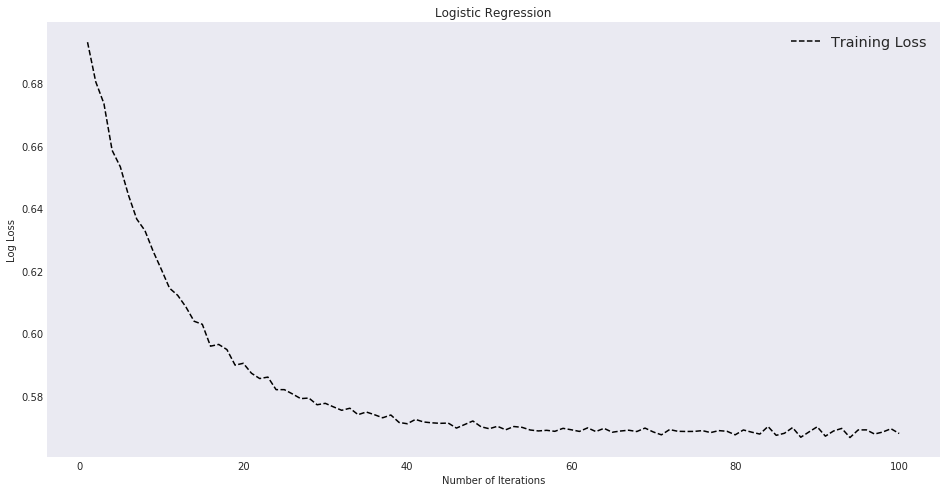

In [61]:
plotErrorCurves(result['history_cost'], title = 'Logistic Regression' )

In [76]:
validationRDD_score = homeGrownLogistic_score(normedValidationRDD_final, result['weight'])

In [77]:
start = time.time()
accuracy,f1score = assess_prediction(validationRDD_score)
print(f'... evaluated in {time.time() - start} seconds.')

True Positive:  3
True Negative:  10229708
False Positive:  161
False Negative:  3524883
Accuracy:  0.7437217893012271
F1 Score:  1.7021035162621806e-06
... evaluated in 1126.7565834522247 seconds.


In the model run above, we can see that the changes in cost over the iterations, as well as the actual performance of the model. A few key things to note: 

* The model is mostly optimized after around 40-50 iterations of GD
* The model is very bad at making predictions. Almost everything is being predicted as 0, which is why the accuracy is being shown as around 75%. 
* The model weights show that all parameters are very close 0, while the intercept is around -1. This suggests that the input variables all have little to no predictive ability. 

These results suggest that our regularization technique might be pushing down our parameters too close to zero. In our next run, we attempt a model without regularization to see if there is an improvement in the f1 score. 

(2) Logistic regression modeled with 10 principal components, no regularization and learning rate of 0.2

In [67]:
## 32 features from feature hashing + 10 PCA components + 100 iterations
start = time.time()
result2 = homeGrownLogistic(normedTrainRDD_final, learningRate=0.2, regType="None", iterNum=100)
print(f'... logistic model trained in {time.time() - start} seconds.')

ITERATION 10: cost = 0.6143838969939648
ITERATION 20: cost = 0.5790618704935805
ITERATION 30: cost = 0.5642693097454179
ITERATION 40: cost = 0.5574284972215157
ITERATION 50: cost = 0.5539364017725842
ITERATION 60: cost = 0.5519667450698342
ITERATION 70: cost = 0.5507426227256564
ITERATION 80: cost = 0.5499124786982128
ITERATION 90: cost = 0.5493077296495781
ITERATION 100: cost = 0.5488426283511375
... logistic model trained in 20711.289948940277 seconds.


_Note_: the Spark job got stuck when running the code above, so it took a lot longer to run than usual.

In [68]:
result2['weight']

array([-1.07727602, -0.2403975 , -0.10024575,  0.00109253,  0.20505754,
       -0.08815916,  0.17808111, -0.28202529,  0.16847152,  0.1468223 ,
        0.03896386])

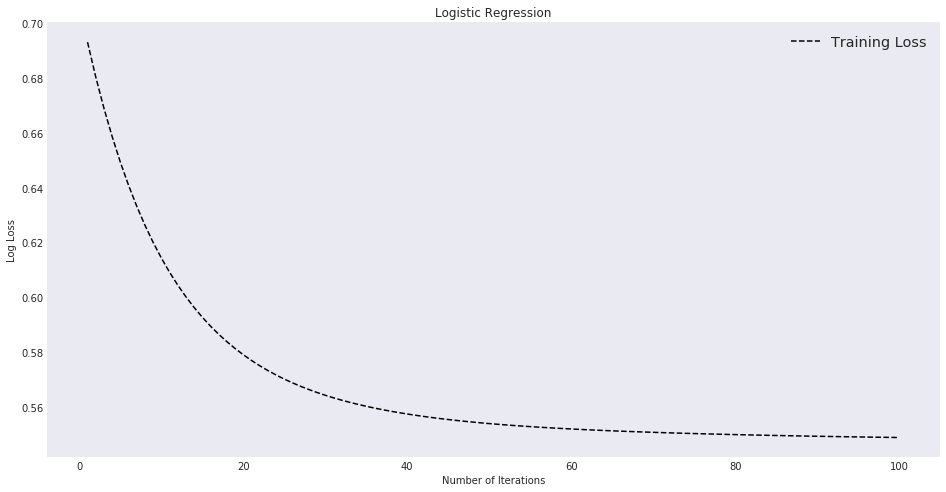

In [69]:
plotErrorCurves(result2['history_cost'], title = 'Logistic Regression' )

In [70]:
validationRDD_score = homeGrownLogistic_score(normedValidationRDD_final, result2['weight'])

In [75]:
start = time.time()
accuracy,f1score = assess_prediction(validationRDD_score)
print(f'... evaluated in {time.time() - start} seconds.')

True Positive:  72398
True Negative:  10159793
False Positive:  70076
False Negative:  3452488
Accuracy:  0.7439020905861282
F1 Score:  0.03948235242790454
... evaluated in 1106.9585571289062 seconds.


The number of true positives increased from 3 to 72,398. Not only are the parameters weights much farther from zero, but the f1 score has improved greatly (although it's still fairly bad in general). 

Due to time constraint, we were unable to grid search the optimal $\lambda$ using k-fold validation.

# Section 5 - Application of Course Concepts

### 5.1 Broadcasting

Broadcasting is an approach in the Spark Map-Reduce paradigm that allows us to make an object available to all worker nodes. A common use of broadcasting is for global information that is required for the data processing tasks that would occur in mappers or reducers. For example, when making a set of predictions in batch using our logistic regression algorithm, we are broadcasting the model weights so that every mapper can apply the model weights for the predictions happening within each node. This allows the entire batch to be split across multiple mappers, each of which has information about the model to make predictions.

### 5.2 Feature Hashing (a.k.a. The Hashing Trick)

Feature hashing, also called the hashing trick, is a technique to encode categorical features. Initially proposed by  Weinberger et. al. (2009), the hashing trick quickly gained popularity and is part of all ML libraries. 

Imagine that you have a dataset containing large amounts of factors and character data. One way to feed this dataset to a ML algorithm is to dummify all factor, text, and unordered categorical data. This creates a new column for each unique value and tags a binary value whether or not an observation contains that particular value. For large data sets, this can drastically increase the dimensional space (adding many more columns) leading to **Curse of Dimensionality**. So, how does the hashing trick solves it?

This problem of high dimensionality can be solved by the hashing trick. We need a hashing function that can generate a numeric hash for a given input. One of the most popular hashing algorithms is, MURMURHASH3. We execute following steps to create a hashing table for our features: 

- Create a hash value for every feature. For example, we generate the hash of “Alabama”, “Alaska” etc as in the diagram below.
- Decide the number of dimensions of the hash table. This is nothing but the value of the table index.
- Divide the hash value by the dimension of the hash table and get the reminder. This is also known as appplying MOD function.
- Assign or add 1 to the feature to the respective index value. Index value here is nothing but the remainder. 
- Please note that for a given number, the remainder must be between 0 and n-1. So if we divide any number by 5 the remainder can only be 0,1,2,3 or 4. These are now index values for us.
- Every index value becomes the feature for the given dataset.

Below is a visual of how feature hashing works.

<img src="FeatureHashing.png"/>

**Advantage of Feature Hashing**
The advantage of using feature hashing is that you can represent text documents of variable-length as numeric feature vectors of equal-length, and achieve dimensionality reduction. In contrast, if you tried to use the text column for training as is, it would be treated as a categorical feature column, with many, many distinct values.

**Disadvantage of Feature Hashing**
One potential downside of using the hashing trick is that multiple, different words may translate to the same index in the vector space (hash collisions) resulting in a loss of precision. But even if it does, it usually doesn’t affect learning (or accuracy) that much.
Another disadvantage of feature hashing is that, once vectors are created, it is difficult to determine which frequency values relate to which terms. When using a vocabulary, with associated index mappings, it is easier to analyse frequencies for particular words. This can make feature hashing unsuitable for some applications.

The following references were found to be useful in understanding feature hashing: 
* https://en.wikipedia.org/wiki/Feature_hashing  
* https://github.com/gcampanella/pydata-london-2019/blob/master/pydata_london_2019.pdf

### 5.3 Normalization  

Normalization is a technique often applied as part of data preparation for machine learning. The goal of normalization is to change the values of numeric columns in the dataset to a common scale, without distorting differences in the ranges of values. For machine learning, not every dataset requires normalization. It is required only when features have different ranges.

For example, consider a data set containing two features, age(x1), and income(x2) where age ranges from 0–100, while income ranges from 20,000–500,000 and higher. So, these two features are in very different ranges. When we do further analysis, like multivariate linear regression, for example, the attributed income will intrinsically influence the result more due to its larger value. But this doesn’t necessarily mean it is more important as a predictor.

These vastly differing ranges may result in gradient descent oscillating back and forth and taking a long time before finding its way to a global/local minimum. 

Normalization avoids these problems by creating new values that maintain the general distribution and ratios in the source data, while keeping values within a scale applied across all numeric columns used in the model.

Four common normalization techniques may be useful:

- scaling to a range
- clipping
- log scaling
- z-score


<img align="center" src="Normalization.png"/>

### 5.4 Regularization 

Regularization is a form of regression, that constrains/regularizes or shrinks the coefficient estimates towards zero. In other words, this technique discourages learning a more complex or flexible model, so as to avoid the risk of overfitting. In any supervised learning context we are concerned with making sure our trained models are going to generalize well to unseen data. A standard least squares model tends to have some variance in it, i.e. the model won’t generalize well for a data set different than its training data. 

Regularization significantly reduces the variance of the model, without substantial increase in its bias. The tuning parameter, λ, controls the impact on bias and variance. As the value of λ rises, it reduces the value of coefficients and thus reducing the variance. This increase in λ is beneficial until a point as it is only reducing the variance (hence avoiding overfitting), without losing any important properties in the data. However, after a certain value, the model starts loosing important properties, giving rise to bias in the model and thus underfitting. Choosing the optimal λ requires setting aside a validation set.

The most common regularization techniques are L-1 norm regularization, sometimes known as LASSO, and L-2 norm regularization, sometimes known as Ridge. 

<img align="center" src="Lasso_Ridge.PNG"/>

The above image shows the constraint functions(green areas) for lasso on left and ridge regression on right along with contours for residual sum of squares(red ellipse). Points on the ellipse share the value of RSS. In this case, the lasso and ridge regression coefficient estimates are given by the ﬁrst point at which an ellipse contacts the constraint region. Since ridge regression has a circular constraint with no sharp points, this intersection will not generally occur on an axis and so the ridge regression coeﬃcient estimates will shrink toward zero but not reach zero. However, the lasso constraint has corners at each of the axes and so the ellipse will often intersect the constraint region at an axis. When this occurs, one of the coeﬃcients will equal zero and for higher dimensions many coefficients will be zero.